In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='leena1234',
    database='ecommerce',
    port=3310
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Leena/Desktop/E_Commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = 'localhost', user = 'root',
                             password = 'leena1234',
                             port = 3310,
                             database = 'ecommerce')


cur = db.cursor()

-------------------BASIC LEVEL UESTIONS-----------

# 1. List all unique cities where customers are located

In [40]:
query = "select distinct customer_city from customers"
cur.execute(query) #this will help in executing uery
data = cur.fetchall() #data ek vriable lia h jo cursor m s sara data fetch krega
data


# 2.Count the number of orders placed in 2017.

In [15]:
query = "select count(order_id) from orders where year(order_purchase_timestamp) = 2017"
cur.execute(query) #this will help in executing uery
data = cur.fetchall() #data ek vriable lia h jo cursor m s sara data fetch krega
"Total orders placed in 2017 are ",data[0][0]


('Total orders placed in 2017 are ', 45101)

 # 3.Find the total sales per category.

In [ ]:
#YE SIRF SAMAJHNE K LIYE HAI
query = "select products.product_category category, sum(payments.payment_value) sales from
products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category"
#yaha payments m join nhi lga skte reson beig k products ka payment m direct connection nhi h 
#beech m ek bridge tble h order_items
# "on" lagate h product and order items m jo common h uspe,
#yaha pe products and pyment m kuch common nhi h isliye product and order m 
# hm common jo h product_id uspe hm "on" condition lagaenge
#ek or bar join lgaenge payments ko join krne k liye jisme payment ki order id
#and ordere_item ki order id merge krenge
#group by krnege product ctegory pe isliye ctaegory and sales name lelia h 

In [29]:
query = """select products.product_category as category, 
round(sum(payments.payment_value),2) as sales 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by product_category"""

cur.execute(query) 
data = cur.fetchall()
data
#we can also create dataframe from it
df = pd.DataFrame(data,columns = ['Category','Sales'])
df.head()

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


# 4. Calculate the percentage of orders that were paid in installments.


In [32]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments
"""

cur.execute(query) 
data = cur.fetchall()
"the percentge of orders that were paid in installments is",data

# so the result shos that this much percent of orders were paid in instllment

('the percentge of orders that were paid in installments is',
 [(Decimal('99.9981'),)])

# 5. Count the number of customers from each state. 

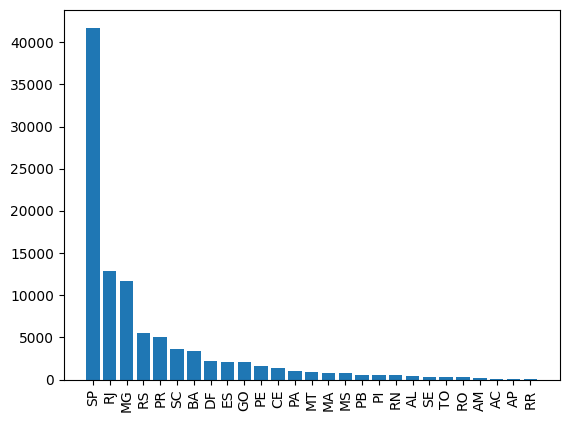

In [37]:
query = """select customer_state,count(customer_id)
from customers group by customer_state"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state","customer_count"])
# we can create dataframe as well
df = df.sort_values(by ="customer_count",ascending = False)
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.show()

In [38]:
df

,state,customer_count
0,SP,41746
4,RJ,12852
2,MG,11635
5,RS,5466
3,PR,5045
1,SC,3637
9,BA,3380
13,DF,2140
8,ES,2033
7,GO,2020


----------Intermediate Level Kuestion---------------

# 1. Calculate the number of orders per month in 2018.

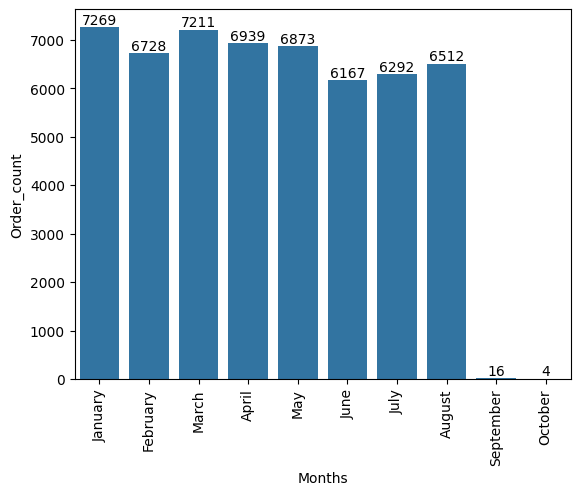

In [66]:
query = """select monthname(order_purchase_timestamp) as months, count(order_id) as counts
from orders where year(order_purchase_timestamp) = 2018
group by months"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Months','Order_count'])
o = ['January','February','March','April','May','June','July','August','September','October']
ax = sns.barplot(x = df['Months'], y = df['Order_count'], data = df, order = o)
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.show()

# ye ax = sns....... krne se  and next line m ax.bar_label krne se 
# ye grph k upr number la dega k kitni vlue h exct

In [ ]:
# 2. Find the average number of products per order, grouped by customer city.

In [71]:
query = """with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg (count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_city","averagePRoductsPErorders"])
df

,customer_city,average_orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,japaratuba,1.00
4106,sebastiao leal,1.00
4107,buriti,3.00
4108,morro agudo de goias,1.00


# 3. Calculate the percentage of total revenue contributed by each product category.

In [ ]:
# mtlb k totl revenu genreted by ech product ctgry/totl revenu * 100
# esa kuch hona h 

In [84]:
query = """
select products.product_category category, 
(sum(payments.payment_value)/ (select sum(payment_value) from payments)) *100 sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Ctgory","Percentge of Revenue"])
df

,Ctgory,Percentge of Revenue
0,perfumery,3.165361
1,Furniture Decoration,8.933649
2,telephony,3.041326
3,bed table bath,10.697529
4,automotive,5.323887
...,...,...
69,cds music dvds,0.007492
70,La Cuisine,0.018199
71,Fashion Children's Clothing,0.004908
72,PC Gamer,0.013583


# 4.Identify the correlation between product price and the number of times a product has been purchased.

In [ ]:
# to ise we cn strt with how mny times product hs been bought

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = 'localhost', user = 'root',
                             password = 'leena1234',
                             port = 3310,
                             database = 'ecommerce')


cur = db.cursor()

query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Ctgory","order_count","price"])
# ab hm correlation dekhenge orice and count m 
arr1 = df['order_count']
arr2 = df['price']
np.corrcoef([arr1,arr2])

#  -1 k mtlb inv proportion vlu 1 k mtlb proportionl vlu, nd here vlu is 0... somethign so no effect of product on price

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [106]:
query = """select *,dense_rank() over(order by revenue desc) as R  from 
(select order_items.seller_id, round(sum(payments.payment_value),2)
as revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as T"""

# select order_items.seller_id, round(sum(payments.payment_value),2)
# as revenue from order_items join payments
# on order_items.order_id = payments.order_id
# group by order_items.seller_id
# ye rnking s phle ki coding h just to undrestnd

cur.execute(query)
data = cur.fetchall()
# data
df = pd.DataFrame(data,columns = ["Seller_ID","REvenue","Rank"])
df


,Seller_ID,REvenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3091,702835e4b785b67a084280efca355756,18.56,3077
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3078
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3079


Advanced Queries

# Calculate the moving average of order values for each customer over their order history.

In [ ]:
# vERY IMPORTANT CONCEPT REGARDING INTERVIEW
# HERE WE WILL CALCULATE AVG BY TAKING 3 MOTNHS i.e taking 3 months moving avergae

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = 'localhost', user = 'root',
                             password = 'leena1234',
                             port = 3310,
                             database = 'ecommerce')


cur = db.cursor()

query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as TableOne"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["Customer_id","Order_Purchase_Timestamp","Payment","Moving_Avg"] )
df

,Customer_id,Order_Purchase_Timestamp,Payment,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


In [ ]:
# Another important question is this

# Calculate the cumulative sales per month for each year.

In [25]:
# remember the conccept of cumulative
# So basic idea is k hr sal hr mahine ki sale nikalein
query = """select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years,months"""


cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns =["Year","Month","payment"])
df

# yaha pe humne monthname use kia tha phle lkn ab month likha kuki kya hora tha
# k month name se jan feb order m nhi are the, lkn numeric krne se joki month use
# krke hua values ascending order m ari thi

,Year,Month,payment
0,2016,9,252.24
1,2016,10,59090.48
2,2016,12,19.62
3,2017,1,138488.04
4,2017,2,291908.01
5,2017,3,449863.60
6,2017,4,417788.03
7,2017,5,592918.82
8,2017,6,511276.38
9,2017,7,592382.92


In [ ]:
# upr wale question ko we r continuing, upr kya tha cumulative ki query abhi tk humne nhi likhi h 
# so here we r writing cumulative ki query

In [29]:
query = """select years,months,payment,sum(payment)
over(order by years, months) as cumulative_payment from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years,months) as TableOne"""


cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns =["Year","Month","payment","Cumulative_Payment"])


# Calculate the year over year growth rate of total sales

In [33]:
query = """select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years"""

cur.execute(query)
data = cur.fetchall()
# data
df = pd.DataFrame(data, columns =["Year","Sales"])
# df
# ye jo humne kia h na ye hr year ki sales ayi hain sirf
# ab hm ek column bnanege jisme previous yr ki sales likhi hongi
# Next step krenge ki formula lgaenge perecentage nikalne ka 

# Calculate the year over year growth rate of total sales” ka matlab hota hai:
# 👉 Har saal ki total sales ko pichhle saal ki sales se compare karke ye nikalna ki growth kitni hui (percentage me)
# jese  2000 m 10,000 ki
#       2002 m 50,000 ki 
# To growth rate hua  (50,000 - 10,000) /  10,000 * 100  

In [38]:
query = """with Table1 as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, payment, lag(payment,1) over(order by years) previous_year from Table1"""
# ab hm ek column bnanege jisme previous yr ki sales likhi hongi
cur.execute(query)
data = cur.fetchall()
# data
df = pd.DataFrame(data, columns =["Year","Sales","Previous_year"])
df

,Year,Sales,Previous_year
0,2016,59362.34,NaN
1,2017,7249746.73,59362.34
2,2018,8699763.05,7249746.73


In [40]:
query = """with Table1 as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment,1) over(order by years))/
lag(payment,1) over(order by years))*100 from Table1"""
# ab yahan hm formula lagaenge
cur.execute(query)
data = cur.fetchall()
# data
df = pd.DataFrame(data, columns =["Year","YearOverYear%Growth"])
df

,Year,YearOverYear%Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [43]:
# To idhr apn phle min function use krenge bcz we need to know the first purchase date
# and for that timestamp we use MIN function i.e MIN(timestamp)
# Har customer ke multiple orders hote hain
# 👉 Hume chahiye customer ka FIRST purchase date

query = """select customers.customer_id,
min(orders.order_purchase_timestamp) as First_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id"""

cur.execute(query)
data = cur.fetchall()
data

[('6e359a57a91f84095cc64e1b351aef8c', '2017-05-15 17:58:25'),
 ('df0aa5b8586495e0ddf6b601122e43a1', '2018-05-09 13:01:24'),
 ('df85b96ba2ce3e49bde101b1614f52ac', '2017-11-26 11:43:57'),
 ('3ccb27f9c7ee205656acef98c19fc061', '2018-04-16 20:46:53'),
 ('154e666b681104319714a99a3ab71e44', '2018-07-31 00:17:40'),
 ('ae8db0691449a44352e7d535ddf78c5e', '2018-05-15 09:10:20'),
 ('4d5110d0a2b5239cb983610da1d18774', '2018-05-16 20:57:48'),
 ('852947b57caab58c544343592f5e06d2', '2018-02-14 10:26:22'),
 ('4b003ee1eabaffe8ff8e6d75394a9b42', '2018-06-11 15:32:06'),
 ('1681471e9172d7e12ba08e9ac9e8628b', '2017-09-05 10:54:17'),
 ('71e31bd9c37b8a1cacc557b87b3e50cb', '2018-03-16 15:49:44'),
 ('a4a00c41b5e3ed88bf0e0bb96576c2b2', '2017-12-15 23:33:32'),
 ('d1d326edcb5fc3e9aadd6e86b7a57910', '2018-02-13 11:28:54'),
 ('620c2e659b5d119813362bfe4bbe8634', '2018-01-31 00:04:39'),
 ('e773252cc3222d0c3ae7694b271e2e32', '2018-03-14 21:15:33'),
 ('6ca7c0e971c24ce0931f148588ef23ce', '2018-04-17 16:54:48'),
 ('f3bb4

In [49]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) as First_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_purchase
from a join orders
on orders.customer_id = a.customer_id
and  orders.order_purchase_timestamp > First_order
and orders.order_purchase_timestamp < 
date_add(First_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""

# ye jo intrval wali line h iska mtlb ye h k humne ek function yaha
# use kia h jo values lerha k frist order se leke 6 motnhs k interval tk
# hume customer chahiye, (basically ye synatx hai 6 motnhs k under find krne ka)

cur.execute(query)
data = cur.fetchall()
data

# iska ans none ayega kyuki esa koi bhi cutomer nhi h jisne 6 months m 
# dubara purchase kia h 

[(None,)]

  # Identify the top 3 customers who spent the most money in each year.

In [56]:
query = """(select orders.order_id,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (order by sum(payments.payment_value)desc)
from orders join payments
on orders.order_id = payments.order_id
group by orders.order_id,
orders.customer_id)"""

cur.execute(query)
data = cur.fetchall()
# data
df = pd.DataFrame(data, columns = ['Order_id','Customer_id','sum_Payment','rank'])
df

,Order_id,Customer_id,sum_Payment,rank
0,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,13664.080078,1
1,736e1922ae60d0d6a89247b851902527,ec5b2ba62e574342386871631fafd3fc,7274.879883,2
2,0812eb902a67711a1cb742b3cdaa65ae,c6e2731c5b391845f6800c97401a43a9,6929.310059,3
3,fefacc66af859508bf1a7934eab1e97f,f48d464a0baaea338cb25f816991ab1f,6922.209961,4
4,f5136e38d1a14a4dbd87dff67da82701,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,5
...,...,...,...,...
99435,e8bbc1d69fee39eee4c72cb5c969e39d,184e8e8e48937145eb96c721ef1f0747,10.070000,29367
99436,f1d5c2e6867fa93ceee9ef9b34a53cbf,a790343ca6f3fee08112d678b43aa7c5,9.590000,29368
99437,4637ca194b6387e2d538dc89b124b0ee,a73c1f73f5772cf801434bf984b0b1a7,0.000000,29369
99438,c8c528189310eaa44a745b8d9d26908b,197a2a6a77da93f678ea0d379f21da0a,0.000000,29369


In [62]:
# but in th ques we need year not order id
# also we want k ranking ka jo partition ho vo year ke basis p ho
# partition k base p ho iska mtlb ye h k jese 2016 ke jitne bhi purchases hain
# kisi bhi customer k usme ranking 1 se start hogi and so on
# then in 2017 ranking will again start from 1 then 2018 m bhi agin 1
# ye mtlb h partition ranking ka
query = """select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)) as D_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id"""

cur.execute(query)
data = cur.fetchall()
# data
df = pd.DataFrame(data, columns = ['Years','Customer_id','sum_Payment','D_rank'])
df

,Years,Customer_id,sum_Payment,D_rank
0,2016,8fbab2ff4df1a7cc9531b14a686bb3ce,117.860001,1
1,2016,bbd6d73964cf368d685856fc8cb04534,139.889999,1
2,2016,4b671f05b6eb9dc1d2c1bae9c8c78536,51.790001,1
3,2016,7812fcebfc5e8065d31e1bb5f0017dae,40.950001,1
4,2016,9031f9dcde5860b34e6c65ac5c796d30,40.790001,1
...,...,...,...,...
99435,2018,7a38bbf1ab93ed3d05e54c57d7e5f66d,63.119999,1
99436,2018,ac81fb6a1f089d191d0a0337ea2bfad0,111.709999,1
99437,2018,8d955047b04c2c2d2a8d47b90f7e71c3,85.239998,1
99438,2018,e1b145fb2721ec02df6d081570bf2ad6,96.690002,1


In [67]:
# Now we want hr year ki top 3 ranks chahiye

query = """select years, customer_id,payment,D_rank
from 
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc )as D_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where D_rank <= 3"""

cur.execute(query)
data = cur.fetchall()
# data
df = pd.DataFrame(data, columns = ['Years','Customer_id','sum_Payment','D_rank'])
df

,Years,Customer_id,sum_Payment,D_rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3
